In [3]:
from jax import numpy as jnp
import numpy as np
from gaussian_toolbox import pdf,conditional
import matplotlib.pyplot as plt
import jax


Linear control modelling with noisy observation Model
----

Here we attempt to model the Linear control on a circle by adding the next level of complexity, i.e making the observation model noisy. This makes the problem non-trivial compared to the example with no noise. 

At first we try to write functions to compute the filter density and prediction density to be used in the expression of the free energy.

State model and observation model for this exampe 1, no action AND 1 dimesional!
----

first we attempt to model the filter density estimation in a model with no action!!!

**s_t+1 = s_t + b + state_noise**

**o_t = s_t + obs_noise**

for this we define a new class named custom_model

In [4]:
class custom_model:
    '''defining a custom linear model of the form : y_t=x_t+b+noise
    This is a special case of the linear control state space model with A=I and action u_t=0 for all t'''
    def __init__(self,b,noise_scale):
        self.b=b
        self.noise_scale=noise_scale
        self.Dz=len(b)
        self.Qz = noise_scale**2 * jnp.eye(self.Dz)
        self.M=jnp.eye(self.Dz)
        self.density = conditional.ConditionalGaussianPDF(M=jnp.array([jnp.eye(self.Dz)]), b=jnp.array([self.b]), Sigma=jnp.array([self.Qz]))
    def compute_y_t(self,x_t):
        return np.matmul(self.M,x_t)+self.b+np.random.normal(0,self.noise_scale,size=(Dz,))
    
    
            

In [2]:
np.shape(jnp.array([jnp.array([np.array((2,))])]))

NameError: name 'np' is not defined

We now create the state and observation models as instances of this class

In [842]:
#defining the model for the 1D example with no action
Dx=1
Dz=1
#defining b for state model, with shape (Dz,)
b=np.array((2,))
#defining noises for botht he models
state_noise=0.3
obs_noise=1.2

#constructing the models
sm=custom_model(b,state_noise)
om=custom_model(np.array((0,)),obs_noise)



Defining the **prior distribution** for the states and sample **s0** from it. Here the prior is defined with the following parameters:

1) mu
2) Sigma

In [843]:
#defining the prior state distribution as a GAUSSIAN with defined mean and Covariance 


prior_noise=0.1
mu=np.array([np.array((1,))]) #shape (1,1)

Sigma=jnp.array([prior_noise*jnp.eye(Dz)])#(1,1,1)
prior=pdf.GaussianPDF(Sigma=Sigma,mu=mu)
key = jax.random.PRNGKey(86)
s0=prior.sample(num_samples=1,key=key)[0][0]#to ensure that s0 has shape (1,)




Simulating the state dynamics for T steps and saving the states in the list **state_timeseries**

In [844]:
T=50
state_timeseries=[]
state_timeseries.append(s0)
for i in range(T):
    s_t=state_timeseries[-1]
    s_t_plus_one=sm.compute_y_t(s_t)
    state_timeseries.append(s_t_plus_one)
print(state_timeseries)

[Array([1.1622026], dtype=float32), array([2.76938964]), array([4.90548359]), array([7.27673686]), array([9.46671075]), array([11.41992589]), array([13.80527196]), array([15.53948648]), array([17.38973868]), array([19.69130211]), array([21.74917384]), array([23.8407552]), array([25.24097148]), array([27.33026501]), array([29.52367517]), array([31.43964627]), array([33.22714742]), array([35.21603455]), array([37.14606316]), array([38.7103041]), array([40.3041161]), array([41.79676289]), array([44.56062996]), array([46.68524534]), array([48.88041429]), array([50.77149389]), array([52.82608748]), array([54.88878761]), array([56.7526056]), array([58.23663209]), array([60.22615761]), array([61.92072791]), array([63.62291695]), array([65.37911201]), array([67.82933599]), array([70.31311964]), array([72.82369201]), array([75.28778552]), array([77.18259688]), array([79.55437691]), array([81.79356802]), array([83.9128862]), array([85.70598471]), array([88.08033172]), array([90.33892352]), array

Now generating observations for these latent states using noisy observation model and saving them in the list **obs_timeseries**

In [845]:
obs_timeseries=[]
#number of data points is always T+1
for i in range(T+1):
    o_t=om.compute_y_t(state_timeseries[i])
    obs_timeseries.append(o_t)
print(obs_timeseries)
    

[array([-0.07394889]), array([2.17739184]), array([3.75967616]), array([7.67316328]), array([9.54784788]), array([10.09225363]), array([13.26017717]), array([13.90944857]), array([17.27250611]), array([19.17807994]), array([23.07699208]), array([25.74706068]), array([25.76776195]), array([24.80020394]), array([31.47298084]), array([31.18860787]), array([31.26761999]), array([33.73684027]), array([38.81890224]), array([38.65179129]), array([40.44436756]), array([38.20408729]), array([45.07154451]), array([45.85075594]), array([49.4519269]), array([51.84101907]), array([52.3062381]), array([52.67119265]), array([57.25474762]), array([58.18009026]), array([58.82405042]), array([61.97844618]), array([64.62533404]), array([63.55978236]), array([66.64538743]), array([71.19866063]), array([71.87277171]), array([76.45636794]), array([78.39659392]), array([81.09035871]), array([83.5439269]), array([86.33861889]), array([84.72577152]), array([87.13632934]), array([92.29488302]), array([94.310765

Plotting the states and observation dynamics with time.


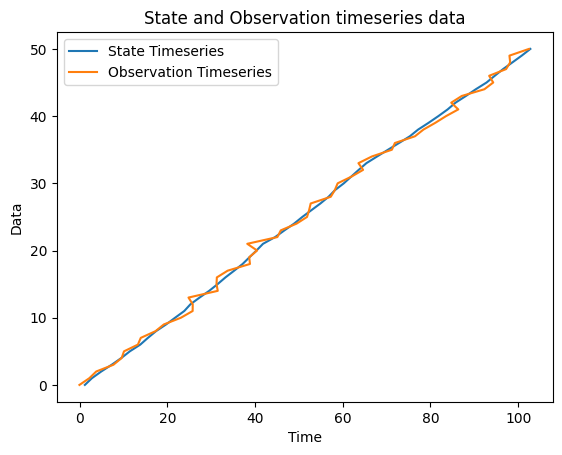

In [846]:
time=np.arange(T+1)
plt.plot(state_timeseries,time,label='State Timeseries')
plt.plot(obs_timeseries,time,label='Observation Timeseries')

plt.xlabel("Time")
plt.ylabel("Data")
plt.title("State and Observation timeseries data")
plt.legend(loc="upper left")
plt.show()

Now since this is done, lets estimate the states just from the observation time series and compare with the actual states. For this we use observation density and prediction density.


In [847]:
state_density=sm.density
obs_density=om.density
type(state_density)

gaussian_toolbox.conditional.ConditionalGaussianPDF

Now we are actually **estimating filter densities** and **prediction densitites** of each step and adding to the prediction_list and filter_list. The first elemet of prediction list is the **prior**.

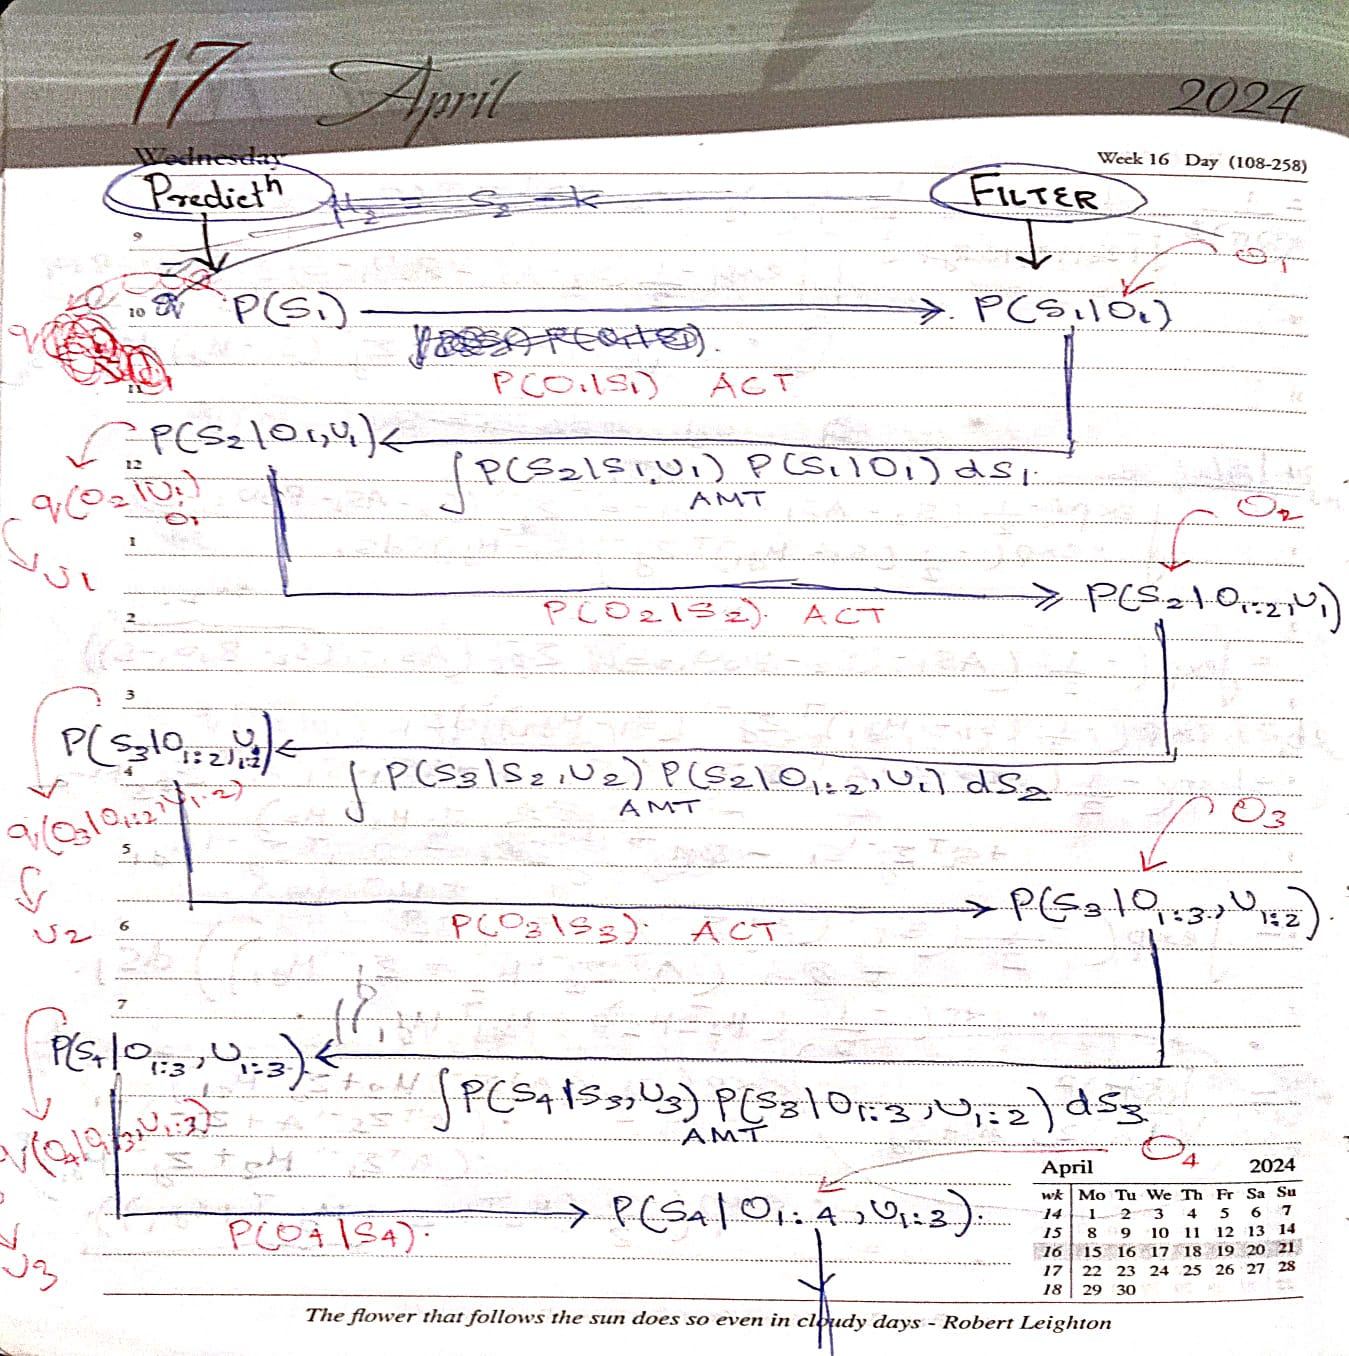

In [848]:
prediction=prior
prediction_list=[]
prediction_list.append(prediction)
filter_list=[]
for i in range(T+1):
    p_s_given_o=obs_density.affine_conditional_transformation(prediction)
    #p_s_given_o becomes filter density only when we input the value of observation.
    filter=p_s_given_o.condition_on_x(np.array([obs_timeseries[i],]))
    filter_list.append(filter)
    
    prediction=state_density.affine_marginal_transformation(filter)
    prediction_list.append(prediction)
    
    


Now we use the filter densities at each step to generate estimations of the states by sampling


In [849]:
state_estimated=[]

for i in range(T+1):
    filter=filter_list[i]
    key = jax.random.PRNGKey(86)

    s_t=filter.sample(num_samples=1,key=key)[0][0]#to ensure that the samples have shape(1,)#no need for sampling, can just use mean !!
    state_estimated.append(s_t)
print(state_estimated)

[Array([1.0871109], dtype=float32), Array([3.0521028], dtype=float32), Array([4.920928], dtype=float32), Array([7.1134796], dtype=float32), Array([9.258357], dtype=float32), Array([11.084183], dtype=float32), Array([13.183852], dtype=float32), Array([14.974386], dtype=float32), Array([17.102346], dtype=float32), Array([19.18243], dtype=float32), Array([21.661303], dtype=float32), Array([24.183395], dtype=float32), Array([26.155664], dtype=float32), Array([27.480066], dtype=float32), Array([29.983265], dtype=float32), Array([31.871794], dtype=float32), Array([33.361076], dtype=float32), Array([35.0665], dtype=float32), Array([37.517017], dtype=float32), Array([39.389896], dtype=float32), Array([41.24504], dtype=float32), Array([42.196377], dtype=float32), Array([44.45333], dtype=float32), Array([46.38416], dtype=float32), Array([48.683628], dtype=float32), Array([51.002872], dtype=float32), Array([52.912945], dtype=float32), Array([54.482014], dtype=float32), Array([56.716373], dtype=fl

Now plotting the observation timeseries, state time series and estimated state time series together to compare.

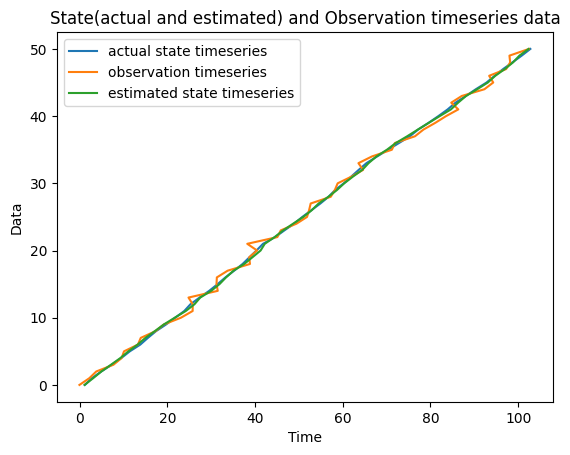

In [850]:

time=np.arange(T+1)
plt.plot(state_timeseries,time,label='actual state timeseries')
plt.plot(obs_timeseries,time,label='observation timeseries')
plt.plot(state_estimated,time,label='estimated state timeseries')
plt.xlabel("Time")
plt.ylabel("Data")
plt.title("State(actual and estimated) and Observation timeseries data")
plt.legend(loc="upper left")
plt.show()

even if the observation time series is noisy, the estimate agrees fairly with the actual series.

State model and observation model for this exampe 2, no action AND 2 dimesional!
----

Here we try to repeat the same work that we did previously but with the a 2D state and observation model!! As before we are not incorporating Action yet: 

**s_t+1 = s_t + b + state_noise**

**o_t = s_t + obs_noise**



In [851]:
#defining the model for the 1D example with no action
Dx=2
Dz=2
#defining b for state model, with shape (Dz,)
b=np.array([1,2])
#defining noises for botht he models
state_noise=0.3
obs_noise=1.2

#constructing the models
sm=custom_model(b,state_noise)
om=custom_model(np.array([0,0]),obs_noise)



Defining the prior distribution as a Gaussian PDF and sampling s0 from it

In [852]:
#defining the prior state distribution


prior_noise=0.1
mu=np.array([np.array([1,5])])

Sigma=jnp.array([prior_noise*jnp.eye(Dz)])
prior=pdf.GaussianPDF(Sigma=Sigma,mu=mu)
key = jax.random.PRNGKey(86)
s0=prior.sample(num_samples=1,key=key)[0][0]#to ensure that s0 has shape (2,)




Simulating the state dynamics to get the state timeseries

In [853]:
T=50
state_timeseries=[]
state_timeseries.append(s0)
for i in range(T):
    s_t=state_timeseries[-1]
    s_t_plus_one=sm.compute_y_t(s_t)
    state_timeseries.append(s_t_plus_one)
print(state_timeseries)

[Array([0.6750767, 4.8177752], dtype=float32), array([1.43350882, 6.7949525 ]), array([2.54598425, 8.62954289]), array([ 3.65176033, 10.34587022]), array([ 4.39492973, 12.05270143]), array([ 5.31780513, 14.08249044]), array([ 6.51249734, 15.73843241]), array([ 7.78951841, 18.20622357]), array([ 9.38356289, 20.39304089]), array([ 9.88186559, 22.38268205]), array([10.43491714, 23.78208886]), array([11.69418148, 25.77586794]), array([12.43050839, 27.65394381]), array([12.95629654, 29.75689617]), array([14.16623212, 32.07145852]), array([14.82010794, 33.83171616]), array([15.80713189, 35.63388153]), array([16.38624963, 38.15734999]), array([16.74832173, 40.05004169]), array([17.92732098, 41.79215673]), array([19.07347702, 43.84927933]), array([20.31652774, 45.55143154]), array([21.57253578, 47.37798102]), array([22.46846289, 49.89227389]), array([23.49919914, 51.74947931]), array([24.41855566, 53.23695428]), array([25.40078433, 55.25506494]), array([26.24166482, 57.14275842]), array([27.31

generating the corresponding observations using the observation model

In [854]:
obs_timeseries=[]
#number of data points is always T+1
for i in range(T+1):
    o_t=om.compute_y_t(state_timeseries[i])
    obs_timeseries.append(o_t)
print(obs_timeseries)
    

[array([-1.02605477,  5.10221406]), array([1.24611413, 5.81618426]), array([0.27290573, 6.92488804]), array([ 3.95986563, 10.40436454]), array([ 6.36091394, 11.60308285]), array([ 5.31041093, 14.40764309]), array([ 7.12598986, 15.40946927]), array([ 9.04556329, 17.28274828]), array([ 9.43611113, 18.63937468]), array([ 9.86478673, 22.4756553 ]), array([11.77966827, 24.18763531]), array([10.70664451, 26.47949494]), array([13.79194735, 29.72545907]), array([14.86982513, 28.67217626]), array([14.86129357, 33.05045653]), array([14.05426064, 34.17091646]), array([14.03357581, 37.19202429]), array([14.53516531, 36.2395163 ]), array([17.09692344, 41.64698996]), array([18.22415091, 40.71222562]), array([19.9868851 , 45.05084244]), array([21.34641615, 45.71024093]), array([20.89372195, 46.44400254]), array([21.75784629, 50.25351755]), array([22.29386465, 49.44638507]), array([24.39496003, 52.64762424]), array([26.01883361, 54.86352609]), array([26.35572567, 55.98111533]), array([27.39994397, 59.

Plotting

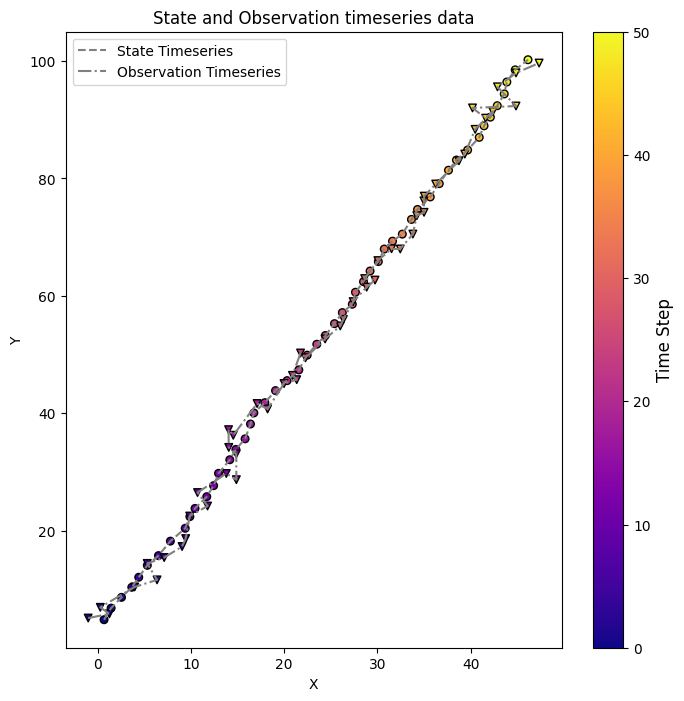

In [855]:
time=np.arange(T+1)
colors = plt.cm.plasma([t / max(time) for t in time])
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

state_x=[state_timeseries[i][0] for i in range(T+1)]
state_y=[state_timeseries[i][1] for i in range(T+1)]

obs_x=[obs_timeseries[i][0] for i in range(T+1)]
obs_y=[obs_timeseries[i][1] for i in range(T+1)]


ax.plot(state_x,state_y,color='gray',linestyle='--',label='State Timeseries')
scatter = ax.scatter(state_x,state_y, c=time, cmap='plasma', edgecolor='k',marker='o', s=30)

ax.plot(obs_x,obs_y,color='gray',linestyle='-.',label='Observation Timeseries')
scatter = ax.scatter(obs_x,obs_y, c=time, cmap='plasma', edgecolor='k',marker='v', s=30)

# Add a colorbar to indicate time evolution
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical')
cbar.set_label('Time Step', fontsize=12)

plt.xlabel("X")
plt.ylabel("Y")
plt.title("State and Observation timeseries data")
plt.legend(loc="upper left")
plt.show()

Now to estimate the filter density and the prediction density define state density and observation density

In [856]:
state_density=sm.density
obs_density=om.density
type(state_density)

gaussian_toolbox.conditional.ConditionalGaussianPDF

Using the prior distribution as a starting point interativily compute filter densities(**logic same as the previous example**)

In [857]:
prediction=prior
prediction_list=[]
prediction_list.append(prediction)
filter_list=[]
for i in range(T+1):
    p_s_given_o=obs_density.affine_conditional_transformation(prediction)

    filter=p_s_given_o.condition_on_x(np.array([obs_timeseries[i],]))
    filter_list.append(filter)
    
    prediction=state_density.affine_marginal_transformation(filter)
    prediction_list.append(prediction)
    
    


Using the filter desities , sample state estimates at different time steps.

In [858]:
state_estimated=[]

for i in range(T+1):
    filter=filter_list[i]
    key = jax.random.PRNGKey(86)

    s_t=filter.sample(num_samples=1,key=key)[0][0]#to ensure that the samples have shape(1,)
    state_estimated.append(s_t)
print(state_estimated)

[Array([0.5542413, 4.830428 ], dtype=float32), Array([1.3835618, 6.639599 ], dtype=float32), Array([1.9445789, 8.314117 ], dtype=float32), Array([ 2.999721, 10.261289], dtype=float32), Array([ 4.3292265, 12.065884 ], dtype=float32), Array([ 5.2007437, 14.065251 ], dtype=float32), Array([ 6.268957, 15.857256], dtype=float32), Array([ 7.5224996, 17.663412 ], dtype=float32), Array([ 8.593342, 19.370419], dtype=float32), Array([ 9.525242, 21.540148], dtype=float32), Array([10.672642, 23.610533], dtype=float32), Array([11.332708, 25.729912], dtype=float32), Array([12.526213, 28.097567], dtype=float32), Array([13.694516, 29.711826], dtype=float32), Array([14.603495, 31.935305], dtype=float32), Array([15.133974, 33.915596], dtype=float32), Array([15.542768, 36.125515], dtype=float32), Array([15.971967, 37.637684], dtype=float32), Array([16.871714, 40.009388], dtype=float32), Array([17.821657, 41.651443], dtype=float32), Array([18.95097 , 43.888573], dtype=float32), Array([20.131098, 45.77753 

Plotting

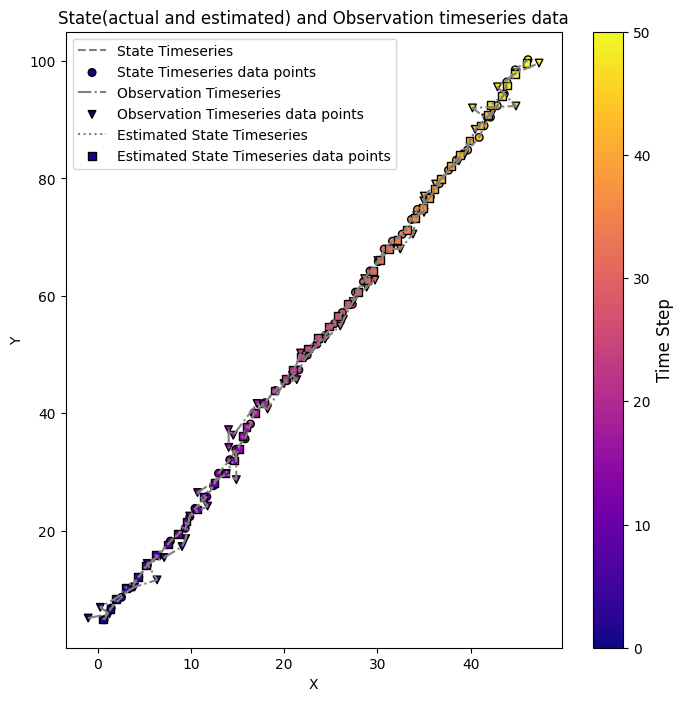

In [859]:
time=np.arange(T+1)
colors = plt.cm.plasma([t / max(time) for t in time])
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

state_x=[state_timeseries[i][0] for i in range(T+1)]
state_y=[state_timeseries[i][1] for i in range(T+1)]

obs_x=[obs_timeseries[i][0] for i in range(T+1)]
obs_y=[obs_timeseries[i][1] for i in range(T+1)]

state_esti_x=[state_estimated[i][0] for i in range(T+1)]
state_esti_y=[state_estimated[i][1] for i in range(T+1)]



ax.plot(state_x,state_y,color='gray',linestyle='--',label='State Timeseries')
scatter = ax.scatter(state_x,state_y, c=time, cmap='plasma', edgecolor='k',marker='o', s=30,label='State Timeseries data points')

ax.plot(obs_x,obs_y,color='gray',linestyle='-.',label='Observation Timeseries')
scatter = ax.scatter(obs_x,obs_y, c=time, cmap='plasma', edgecolor='k',marker='v', s=30,label='Observation Timeseries data points')

ax.plot(state_esti_x,state_esti_y,color='gray',linestyle=':',label='Estimated State Timeseries')
scatter = ax.scatter(state_esti_x,state_esti_y, c=time, cmap='plasma', edgecolor='k',marker='s', s=30,label='Estimated State Timeseries data points')

# Add a colorbar to indicate time evolution
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical')
cbar.set_label('Time Step', fontsize=12)

plt.xlabel("X")
plt.ylabel("Y")
plt.title("State(actual and estimated) and Observation timeseries data")
plt.legend(loc="upper left")
plt.show()

**Remarks on the graph????**

----
Modelling an agent in 2d plane, with preferred state being the unit circle with noisy observation channel
---
----
Now we are gonna use this framework of obtaining filter densities to estimate the Free energy and model an agent in 2d plane with preferred state being a circle, with a noisy observation channel. This is an extention of previous two examples with the incorporation of action and decision making!

The state model is then :  **s_t = As_t-1 + B_u*u_t-1 + b + noise** 

With
>A: identity matrix

>b: [0,del_theta]

>B_u: [B,0]

>noise: 2d gaussian

Hence the parameters involeved in the state model are:
1) **del_theta**: how much rotation with each time step

2) **B**: How much radial displacement away/towards the origin with each chosen action

3) **noise scale**: variance of the white noise


The class has a function that computes the state transition given previous state and the action.

It also has the object density which here is a Linear Control Conditional Gaussian PDF

In [5]:
class state_model:
    def __init__(self,A,B_u,b,noise_scale):
        self.A=A
        self.B_u=B_u
        self.b=b
        self.Dz=np.shape(A)[1]
        self.Du=np.shape(B_u)[1]
        self.noise_scale=noise_scale
        self.Qz = noise_scale**2 * jnp.eye(self.Dz)
        self.density=conditional.LinearControlConditionalGaussianPDF(M=np.array([self.A,]),b=np.array([self.b,]),B_u=np.array([self.B_u,]),Sigma=np.array([self.Qz,]),num_cond_dim=self.Dz,num_control_dim=self.Du)
    def compute_z_t_plus_one(self,z_t,u_t):
        return np.matmul(self.A,z_t)+np.matmul(self.B_u,u_t)+self.b+np.random.normal(0,self.noise_scale,size=(Dz,))
        

The Observation Model is simply **o_t=s_t + noise**. We are defining a class to model it. The only parameter here is the noise scale and the size of observation, Dx. 

1) **noise_scale**: controls the noise of the model
2) **Dx**: defines the dimension of the model

Just like the state model, it has a function to compute o_t given z_t, and the object density which is defined as a Conditional Gaussian PDF here

In [861]:
class obs_model:
    def __init__(self,Dx,noise_scale):
        self.noise_scale=noise_scale
        self.Dx=Dx
        self.M=np.eye(self.Dx)
        self.b=np.zeros(self.Dx)
        self.Qz = noise_scale**2 * jnp.eye(self.Dx)
        self.density = conditional.ConditionalGaussianPDF(M=jnp.array([self.M]), b=jnp.array([self.b]), Sigma=jnp.array([self.Qz]))
    def compute_x_t(self,z_t):
        return z_t+np.random.normal(0,self.noise_scale,size=(Dx,))
        

Now we are going to use the classes defined before to work a specific instance of the model, defining everything simmilar to the zero noise example.

Accordingly the dimensions, the parameters for observation and state model are defined and the **state model** and **observation model** instances created(**sm and om**).

In [6]:

Dz=2
Dx=2
Du=1


#defining the state tranistion matrices: s_t = As_t-1 + Bu_t-1 + b + noise


A=jnp.eye(2)

# lets choose del_theta = 0.1 radians
del_theta=0.1
b=jnp.array([0,del_theta])

# choosing B_u as follows
B=1
B_u=jnp.array([[B,],[0,]])

#assume noise to be a a gaussian of mean zero and defined variance
state_noise=0.0001

sm=state_model(A=A,b=b,B_u=B_u,noise_scale=state_noise)


2025-02-10 05:26:13.187805: W external/xla/xla/service/platform_util.cc:206] unable to create StreamExecutor for CUDA:0: : CUDA_ERROR_OUT_OF_MEMORY: out of memory


In [12]:
a=sm.density
x=np.array([[1,0]])
u=np.array([[1]])
print(np.shape(x))
print(a.get_conditional_mu(x=x,u=u))

(1, 2)
[[[2.  0.1]]]


In [863]:
#Only paramter here is the obs_noise which is defined as follows!!
obs_noise=0.01
om=obs_model(Dx=Dx,noise_scale=obs_noise)


Now we are defining the distribution of preferred observations **p(o|c)** as a GaussianPDF, to be used later in the estimation of EFE.Parameters involved are:


1) **R**: defined the preferred radial distance
2) **sig_1**: defines how sharp the distribution of r values are around the R value(smaller value preferred)
3) **sig_2**: defines how sharp the distribution of thera values are around 0(larger value preferred)

In [864]:

#defining the preferred observations
R=5
sig_1=0.00000001
sig_2=7

mu_preferred = jnp.array([jnp.array([R,0])])
sigma_preferred = jnp.array([jnp.array([[sig_1,0],[0,sig_2]])])

preff_distri=pdf.GaussianPDF(Sigma=sigma_preferred,mu=mu_preferred)


Creating variables state_density and obs_density from the respective model instances.

In [865]:
state_density=sm.density
obs_density=om.density

Definig the **prior distribution** of the states as a GaussianPDF. Parametrs involved here are:

1) **prior_noise**: variance associated with this distribution
2) **mu**: The mean position of the prior distributions

In [866]:
#defining the prior state distribution p(s0)


prior_noise=0.1
mu=np.array([np.array([1,5])])

Sigma=jnp.array([prior_noise*jnp.eye(Dz)])
prior=pdf.GaussianPDF(Sigma=Sigma,mu=mu)



Defining the funtion **compute_q_o_t_plus_one_given_u_t** which gives the distribution **q(o_t+1|u_t)** given the the observation density **p(o_t+1|s_t+1)** and the prediction density **p(s_t+1|u_{1:t},o_{1:t})**. This term is needed in the computation of the KL divergence term in the expression of EFE at the next instant t+1.

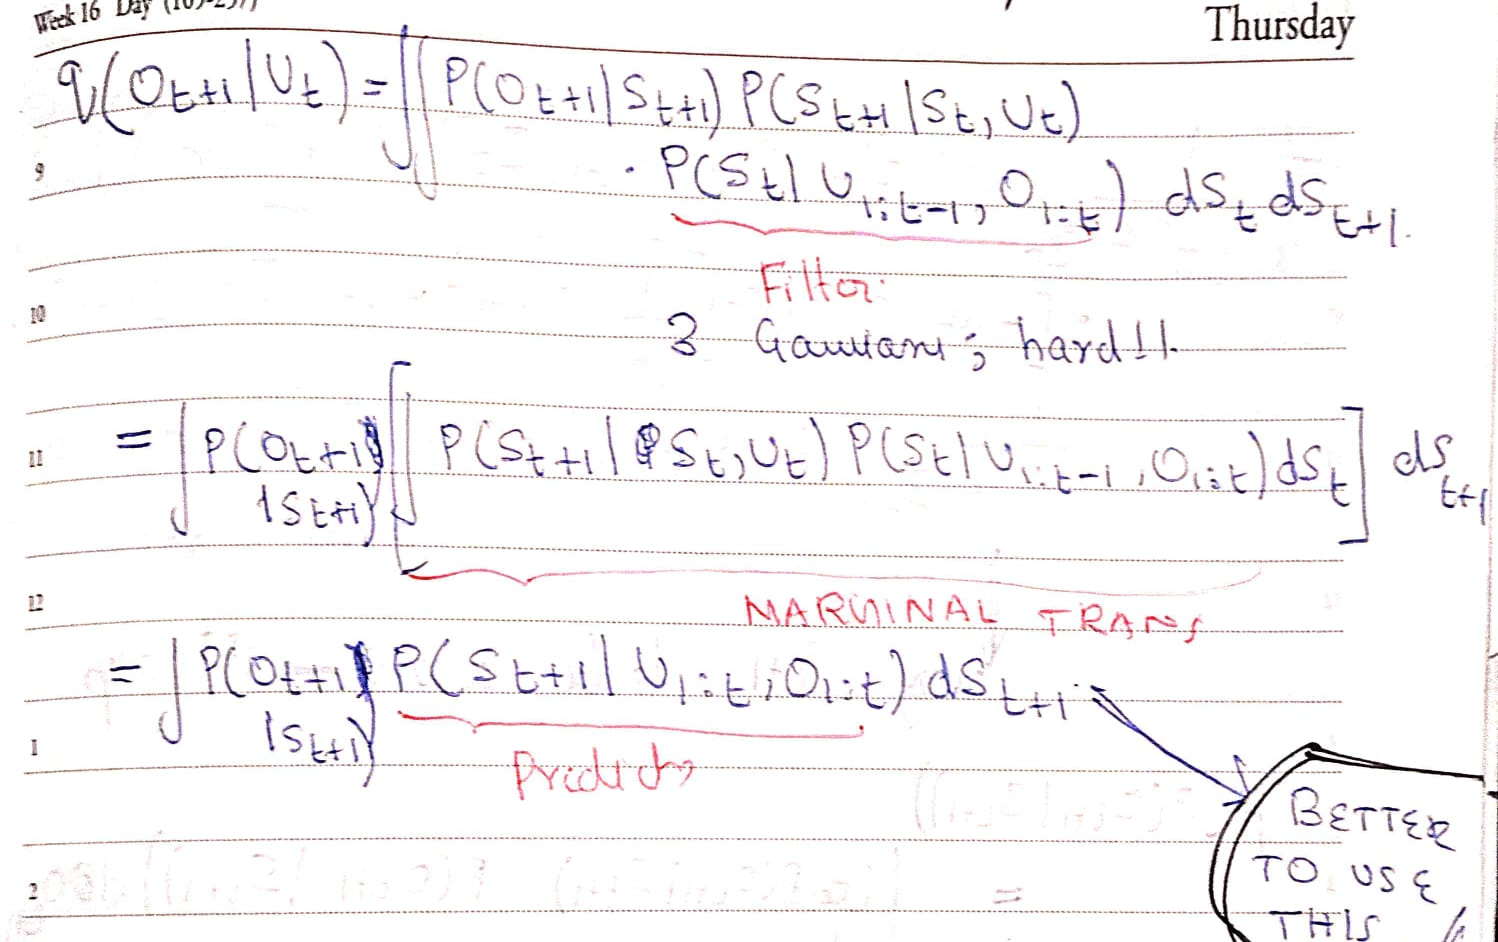

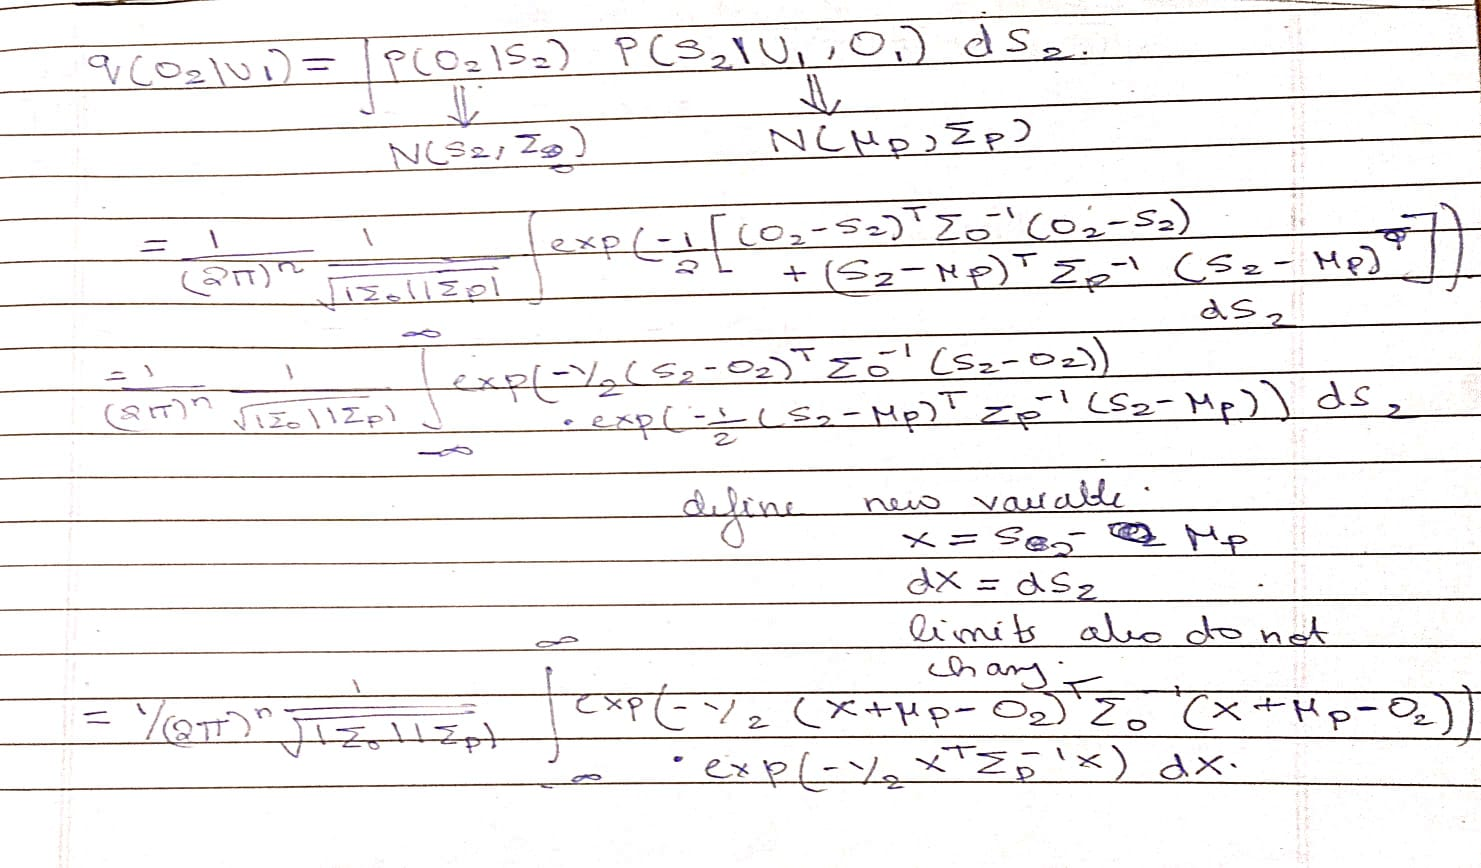

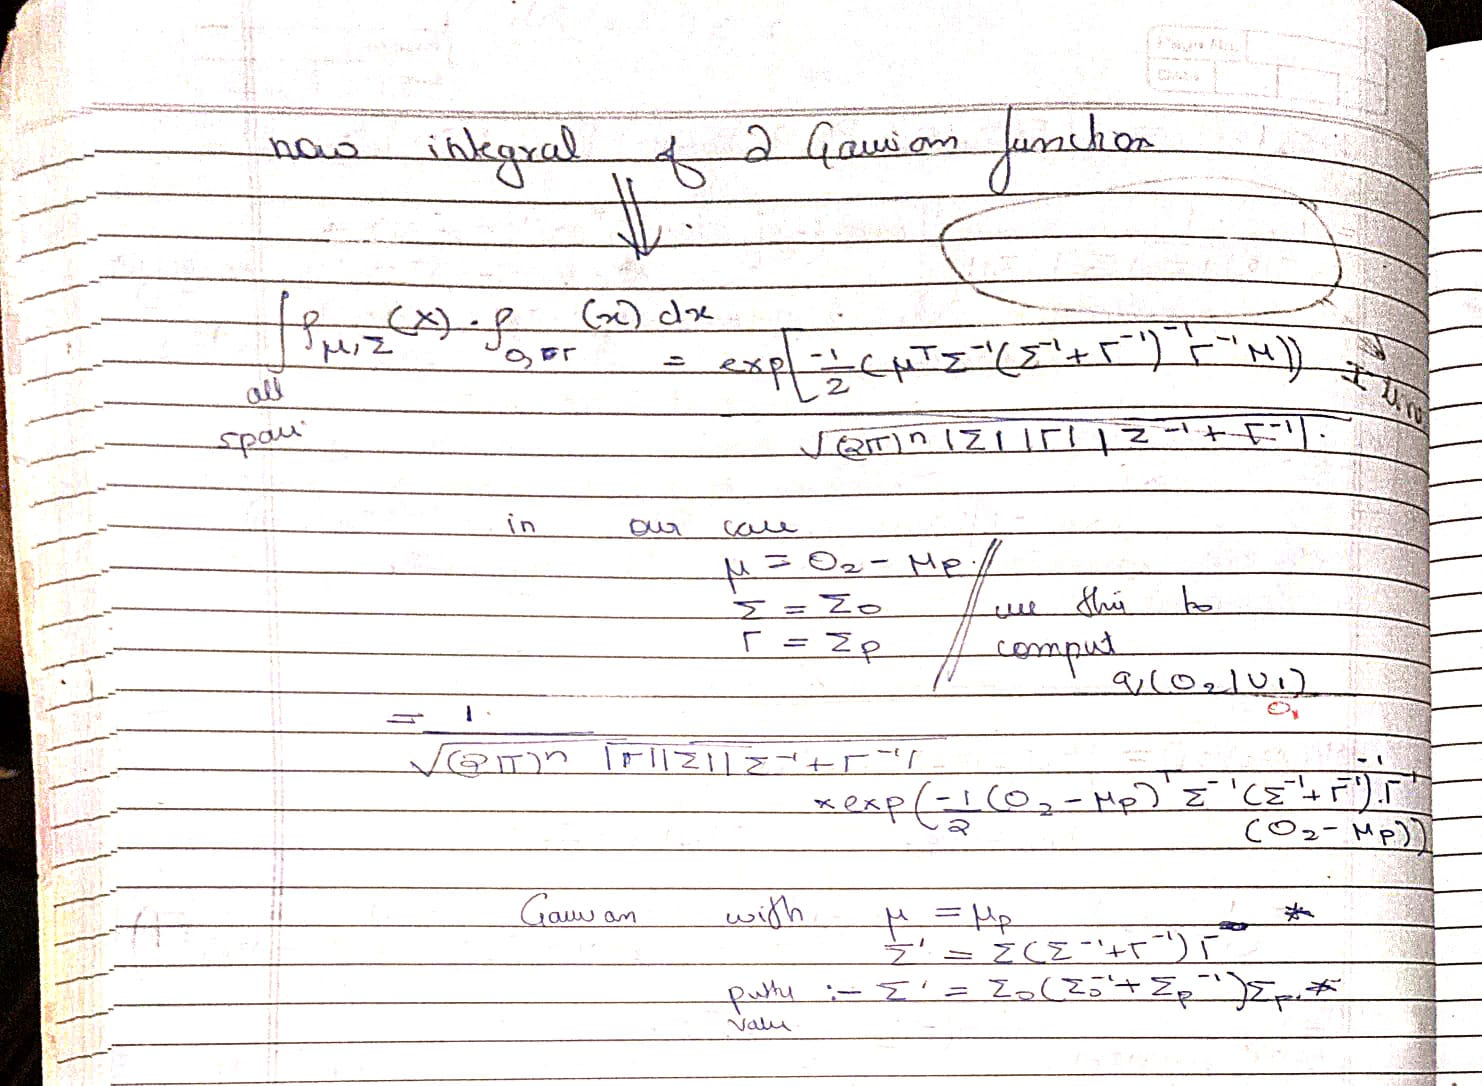





In [867]:
def compute_q_o_t_plus_one_given_u_t(prediction_density,obs_density):
    '''computes q(o_t+1|u_t) required to compute KL divergence term in the 
    EFE expression FOR A PARTICULAR TIME INSTANCE by integrating the observation
    density p(o_t+1|s_t+1) with the prediction density p(s_t+1|u_{1:t},o_{1:t})'''
    sigma_p_inv=np.linalg.inv(prediction_density.Sigma)
    sigma_o_inv=np.linalg.inv(obs_density.Sigma)
    sigma_o=obs_density.Sigma
    sigma_p=prediction_density.Sigma
    
    
    mu=prediction_density.mu
    
    sigma=np.matmul(sigma_o,np.matmul(sigma_o_inv+sigma_p_inv, sigma_p))
    q_o_t_plus_one_given_u_t=pdf.GaussianPDF(Sigma=sigma,mu=mu)
    return q_o_t_plus_one_given_u_t

    

Define the function to compute KL diveregnce between two gaussian distributions. Refer to the notes for the proof.

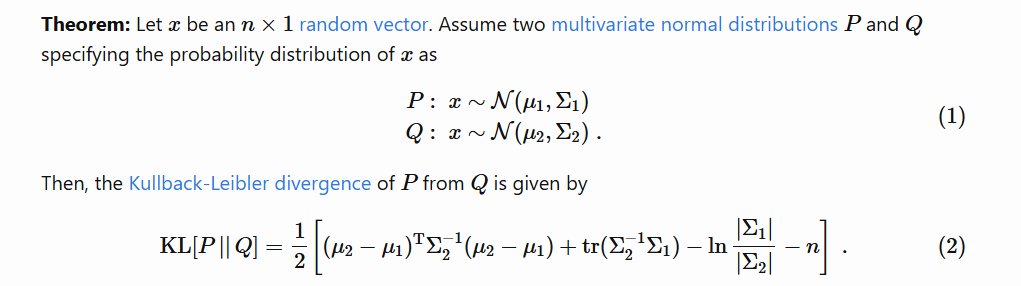

In [868]:
def compute_KL_div_gaussian(gaussian_1,gaussian_2):
    mu_1=gaussian_1.mu[0]
    mu_2=gaussian_2.mu[0]
    sigma_1=gaussian_1.Sigma[0]
    sigma_2=gaussian_2.Sigma[0]
    return 0.5*(jnp.log(jnp.linalg.det(sigma_2)/jnp.linalg.det(sigma_1)) - 2 + jnp.trace(jnp.matmul(jnp.linalg.inv(sigma_2),sigma_1)) + jnp.matmul((mu_1-mu_2).T,jnp.matmul(jnp.linalg.inv(sigma_2),(mu_1-mu_2))))
        

These two functios should suffice to compute the First term in the expression of EFE.
Now we will define a function that computes the **term2**, i.e the entropy term in the EFE expression.

The entropy term turns out to be indpendent of the state distribution in this case, hence it takes the simpler form
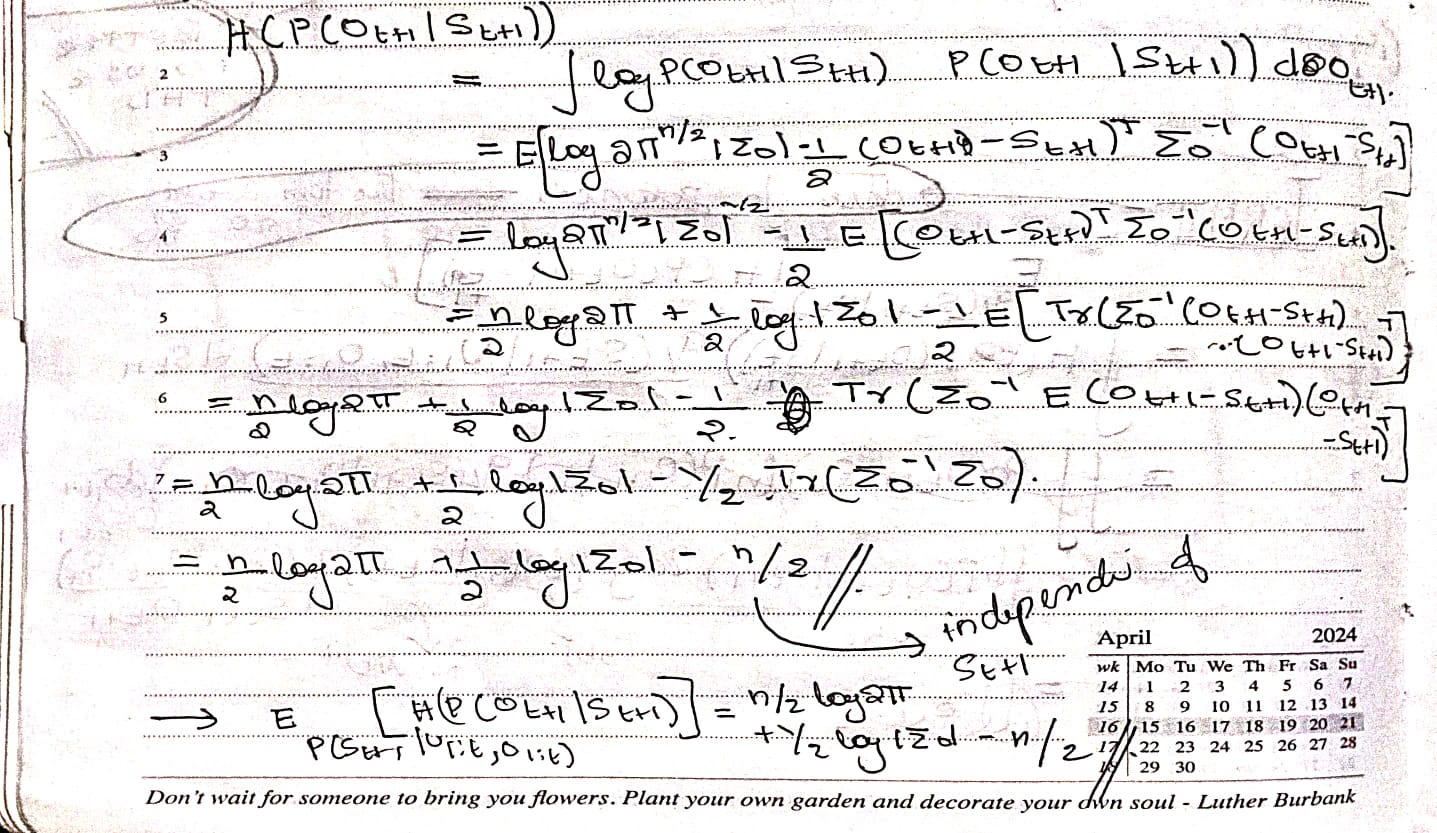

In [885]:
def compute_expected_entropy(obs_density):
    # s_t=prediction.sample(num_samples=1,key=key)[0][0]
    # obs_density=om.compute_density(s_t)   
    n=obs_density.Dx
    det_sigma_obs=np.linalg.det(obs_density.Sigma)
    # print(det_sigma_obs)
    return (0.5*n)*np.log(2*np.pi) + 0.5*np.log(det_sigma_obs) - 0.5*n

    

Using all these functions , we compute a function to compute the EFE given **action** and **prediction density**!!

In [886]:
def compute_G_next_step(prediction,obs_density):
    q_o_t_plus_one_given_u_t=compute_q_o_t_plus_one_given_u_t(prediction,obs_density)
    term_1=compute_KL_div_gaussian(q_o_t_plus_one_given_u_t,preff_distri)
    term_2=compute_expected_entropy(obs_density)
    return term_1 + term_2

    
    

**Implementation of this model**


In [887]:
#setting prediction initially as prior
prediction=prior
state_timeseries=[]
obs_timeseries=[]
filter_list=[]
prediction_list=[]
action_list=[]
prediction_list.append(prediction)


for i in range(T+1):
    
    #to generate observations we sample s_t and o_t, not part of the agent performing active inference
    #ENVIRONMENT DYNAMICS
    #TODO:Need to make sepraete dynamcis for the internal model and the actual environment model seperately
    
    s_t=prediction.sample(num_samples=1,key=key)[0][0] #P(Zt|x1:t-1) P(Zt|Zt-1)

   
    o_t=om.compute_x_t(s_t)
    state_timeseries.append(s_t)
    obs_timeseries.append(o_t)
    
    
    #AGENT DYNAMICS 
    #now the agent only has access to o_t, using this it performs estimation of G of the next step to perfomr decision making
    #at filter density computes
    p_s_given_o=obs_density.affine_conditional_transformation(prediction)
    filter=p_s_given_o.condition_on_x(np.array([o_t]))
    filter_list.append(filter)
    #now the filter density is used to estimate prediciton densities of s_t+1 for each of the possible actions +1 and -1.
    #This filter density aling with obs_density is passed onto the deifned compute_G_next_step function
    G_plus_one=compute_G_next_step((state_density.set_control_variable(np.array([np.array([+1])]))).affine_marginal_transformation(filter),obs_density)
    G_minus_one=compute_G_next_step((state_density.set_control_variable(np.array([np.array([-1])]))).affine_marginal_transformation(filter),obs_density)
    
    #The EFE values are compared and decision made
    
    if G_plus_one>G_minus_one:
        u_t=-1
    else:
        u_t=+1
    action_list.append(u_t)
    
    # the prediction density computed again for the chosen action and the iteration is continued, making decisions and computing predcition densties
    prediction=(state_density.set_control_variable(np.array([np.array([u_t])]))).affine_marginal_transformation(filter)
    prediction_list.append(prediction)
    
    
    
    
    
    

                


Now the filter densities computed at each step in the previous code snippet is used to estiamte the state of the agent.

In [888]:
state_estimated=[]

for i in range(T+1):
    filter=filter_list[i]
    key = jax.random.PRNGKey(86)

    s_t=filter.sample(num_samples=1,key=key)[0][0]#to ensure that the samples have shape(1,)
    state_estimated.append(s_t)
print(state_estimated)

[Array([0.7639296, 4.840796 ], dtype=float32), Array([2.1910515, 5.0290375], dtype=float32), Array([3.7711911, 5.1364717], dtype=float32), Array([5.261202, 5.230869], dtype=float32), Array([3.695905 , 5.3429837], dtype=float32), Array([5.187748 , 5.4384093], dtype=float32), Array([3.72864 , 5.550234], dtype=float32), Array([5.221817 , 5.6464076], dtype=float32), Array([3.772144 , 5.6875553], dtype=float32), Array([5.2663274, 5.7842927], dtype=float32), Array([3.7425988, 5.813249 ], dtype=float32), Array([5.237562 , 5.9104247], dtype=float32), Array([3.719953, 5.968562], dtype=float32), Array([5.215537, 6.066086], dtype=float32), Array([3.804894, 6.086884], dtype=float32), Array([5.3009806, 6.1846886], dtype=float32), Array([3.8319833, 6.2550664], dtype=float32), Array([5.328484, 6.353104], dtype=float32), Array([3.839756, 6.475482], dtype=float32), Array([5.3366027, 6.573714 ], dtype=float32), Array([3.8149676, 6.7011647], dtype=float32), Array([5.312107 , 6.7995605], dtype=float32), A

Plotting the Dynamics of this active agent!!

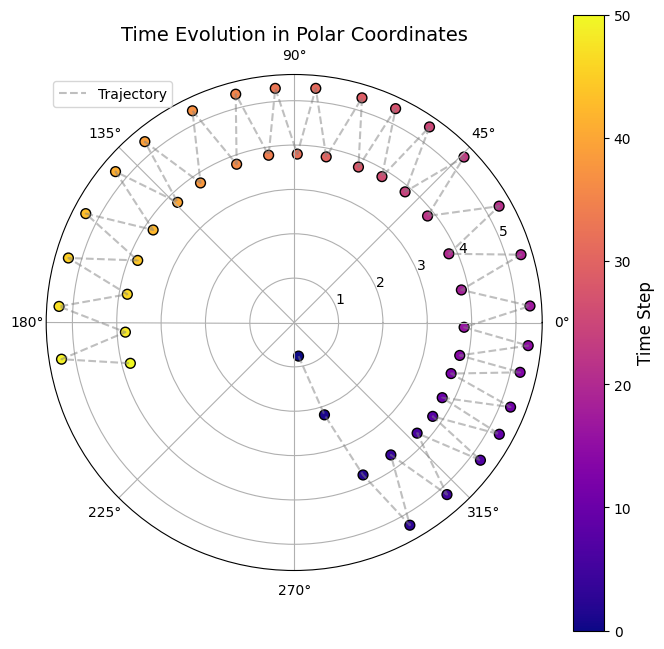

In [889]:
import matplotlib.pyplot as plt


data = state_estimated


r_values = [point[0] for point in data]
theta_values = [point[1] for point in data]


time_steps = range(len(data))
colors = plt.cm.plasma([t / max(time_steps) for t in time_steps])  # Cooler to warmer colors

# Plot in polar coordinates
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, polar=True)



# Plot the lines connecting the points
ax.plot(theta_values, r_values, color='gray', alpha=0.5, linestyle='--', label="Trajectory")

# Plot the scatter points
scatter = ax.scatter(theta_values, r_values, c=time_steps, cmap='plasma', edgecolor='k', s=50)

# Add a colorbar to indicate time evolution
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical')
cbar.set_label('Time Step', fontsize=12)

# Set plot title
ax.set_title('Time Evolution in Polar Coordinates', fontsize=14)
ax.legend(loc="upper left")

plt.show()


As expected the dynamics revolves around the preferred state that is the circle of given radius.

---
Modelling an inhomogeneous state space
---

The Entropy term doesnt have any influence in the decision making as the value of that term is same throughout the state space. To characterize to role of that term we define a custom obs model which has different noise values depending on the radial distance of the state from the origin. For a defined radius R, it takes a particular value if s_t[0]<R and another value if s_t[0]>R.

We are in addition defining a new function compute_density which returns the associated Conditional Gaussian given the input of the state. **NOTE:** The agent doesnt have access to the state information, but this function rather models the environment the environment/perception changes as the state agent moves from region_1 to region_2 in the state space!!


In [934]:
class inhomo_obs_model():
    '''Defining a special obs model where the noise term depends on the state'''
    def __init__(self,Dx,R,noise_scale_1,noise_scale_2):
        self.R=R
        self.noise_scale_1=noise_scale_1
        self.noise_scale_2=noise_scale_2
        self.Dx=Dx
    def compute_x_t(self,z_t):
        if z_t[0]<R:
             return z_t+np.random.normal(0,self.noise_scale_1,size=(Dx,))
        else:
             return z_t+np.random.normal(0,self.noise_scale_2,size=(Dx,))
    def compute_density(self,z_t):
        if z_t[0]<self.R:
            Qz = self.noise_scale_1**2 * jnp.eye(self.Dx)
            M=jnp.eye(self.Dx)
            density = conditional.ConditionalGaussianPDF(M=jnp.array([jnp.eye(self.Dx)]), b=jnp.array([jnp.zeros(self.Dx)]), Sigma=jnp.array([Qz]))
            return density
        else:
            Qz = self.noise_scale_2**2 * jnp.eye(self.Dx)
            M=jnp.eye(self.Dx)
            density = conditional.ConditionalGaussianPDF(M=jnp.array([jnp.eye(self.Dx)]), b=jnp.array([jnp.zeros(self.Dx)]), Sigma=jnp.array([Qz]))
            return density
            
            
    

Accordingly we are modifying the **compute_expected_entropy** function to input onlt the **prediction density** (and not the obs_density). From this the s_t+1 is predicted and that data is used to determine whether the agent is in region_1 or region_2 and the associated **obs_density** there is used to comute the expected entropy.

In [935]:
def compute_expected_entropy_modified(prediction):
    s_t=prediction.sample(num_samples=1,key=key)[0][0]
    # print(s_t[0])
    obs_density=om.compute_density(s_t)   
    n=obs_density.Dx
    det_sigma_obs=np.linalg.det(obs_density.Sigma)
    return (0.5*n)*np.log(2*np.pi) + 0.5*np.log(det_sigma_obs) - 0.5*n

    

After comparing generic values of term_1 and term_2 in our example, we add a **prefactor 1e-9** to make the effects of term_2 more noticeable in the model.

In [936]:
def compute_G_next_step(prediction,obs_density):
    q_o_t_plus_one_given_u_t=compute_q_o_t_plus_one_given_u_t(prediction,obs_density)
    term_1=compute_KL_div_gaussian(q_o_t_plus_one_given_u_t,preff_distri)
    term_2=compute_expected_entropy_modified(prediction)
    # term_2=0
    # print(term_1)
    # print(term_2)
    return 1e-9*term_1 + term_2

    
    

Defining the state model(**no change except B=1.5**)

In [937]:

Dz=2
Dx=2
Du=1


#defining the state tranistion matrices: s_t = As_t-1 + Bu_t-1 + b + noise


A=jnp.eye(2)

# lets choose del_theta = 0.1 radians
del_theta=0.1
b=jnp.array([0,del_theta])

# choosing B_u as follows
B=1.5
B_u=jnp.array([[B,],[0,]])

#assume noise to be a a gaussian of mean zero and defined variance
state_noise=0.0001

sm=state_model(A=A,b=b,B_u=B_u,noise_scale=state_noise)
state_density=sm.density


Defining the observation model as an instance of the new class **inhomo_obs_model**, with the noise values such that there is a low observation noise region beyond **R=5.8**

In [938]:
obs_noise_1=1
obs_noise_2=0.00000000001
om=inhomo_obs_model(Dx=Dx,noise_scale_1=obs_noise_1,noise_scale_2=obs_noise_2,R=5.8)


Defining the preferred observations here(**No change**)

In [939]:

#defining the preferred observations
R=5
sig_1=0.00000001
sig_2=7

mu_preferred = jnp.array([jnp.array([R,0])])
sigma_preferred = jnp.array([jnp.array([[sig_1,0],[0,sig_2]])])

preff_distri=pdf.GaussianPDF(Sigma=sigma_preferred,mu=mu_preferred)


Defining the prior distribution(**no change**)

In [940]:
#defining the prior state distribution


prior_noise=0.1
mu=np.array([np.array([1,5])])

Sigma=jnp.array([prior_noise*jnp.eye(Dz)])
prior=pdf.GaussianPDF(Sigma=Sigma,mu=mu)



Implementing the model.

Changes are

1) there is an additional condition of both EFE being equal, in that case u_t=0 is chosen.
2) obs_density computed using compute_density seperately inside the iteration as it depends on the s_t.

**NOTE:** In contrast to the previous example the obs_density used at first to compute the filter density(at time t, hence depends on **s_t**) may not be same as the one used in the compute_cross_entropy function(at t+1 hence depends on **s_t+1**) . Therefore the compute_density function is called seperately in the cross entropy computation again corresponding to the preiciton density of **t+1**, not **t**.

In [941]:
prediction=prior
state_timeseries=[]
obs_timeseries=[]
filter_list=[]
prediction_list=[]
action_list=[]
prediction_list.append(prediction)
T=50
key = jax.random.PRNGKey(86)

for i in range(T+1):
    #to generate observations we sample s_t and o_t, not part of the agent performing active inference
    s_t=prediction.sample(num_samples=1,key=key)[0][0]
    obs_density=om.compute_density(s_t)
    o_t=om.compute_x_t(s_t)
    state_timeseries.append(s_t)
    obs_timeseries.append(o_t)
    #now the agent only has access to o_t, using this it performs estimation of G of the next step to perfomr decision making
    p_s_given_o=obs_density.affine_conditional_transformation(prediction)
    filter=p_s_given_o.condition_on_x(np.array([o_t]))
    filter_list.append(filter)
    # print('step ',i,'of the interation')
    # print('------------------------------')
    # print('position with +1')
    G_plus_one=compute_G_next_step((state_density.set_control_variable(np.array([np.array([+1])]))).affine_marginal_transformation(filter),obs_density)
    # print('position with -1')
    G_minus_one=compute_G_next_step((state_density.set_control_variable(np.array([np.array([-1])]))).affine_marginal_transformation(filter),obs_density)
    # print(G_plus_one,G_minus_one,s_t[0])
    if G_plus_one>G_minus_one:
        u_t=-1
    elif G_plus_one==G_minus_one:
        u_t=0
    else:
        u_t=+1
    action_list.append(u_t)
    
    
    prediction=(state_density.set_control_variable(np.array([np.array([u_t])]))).affine_marginal_transformation(filter)
    prediction_list.append(prediction)
    
    
    
    
    
    

                


356120670.0
[0.83787707]
1542894300.0
[0.83787707]
105690900.0
[0.83787707]
860229300.0
[0.83787707]
58530916.0
[0.83787707]
416701730.0
[0.83787707]
213015020.0
[-49.82863447]
127292620.0
[0.83787707]
453345570.0
[-49.82863447]
6206.523
[0.83787707]
1017468350.0
[-49.82863447]
114160190.0
[-49.82863447]
453283300.0
[-49.82863447]
5978.9927
[0.83787707]
1017375040.0
[-49.82863447]
114128910.0
[-49.82863447]
453220960.0
[-49.82863447]
5755.222
[0.83787707]
1017281660.0
[-49.82863447]
114097656.0
[-49.82863447]
453158660.0
[-49.82863447]
5535.7383
[0.83787707]
1017188300.0
[-49.82863447]
114066400.0
[-49.82863447]
453096350.0
[-49.82863447]
5320.5435
[0.83787707]
1017095040.0
[-49.82863447]
114035140.0
[-49.82863447]
453034080.0
[-49.82863447]
5109.6367
[0.83787707]
1017001660.0
[-49.82863447]
114003896.0
[-49.82863447]
452971780.0
[-49.82863447]
4903.0186
[0.83787707]
1016908300.0
[-49.82863447]
113972640.0
[-49.82863447]
452909470.0
[-49.82863447]
4700.6895
[0.83787707]
1016815000.0
[-

Using the filter densitites computed at each time, the states are estimated.

In [942]:
state_estimated=[]

for i in range(T+1):
    filter=filter_list[i]
    key = jax.random.PRNGKey(86)

    s_t=filter.sample(num_samples=1,key=key)[0][0]#to ensure that the samples have shape(1,)
    state_estimated.append(s_t)
print(state_estimated)

[Array([0.7342857, 4.819573 ], dtype=float32), Array([2.1882591, 5.0441155], dtype=float32), Array([3.5211208, 5.119117 ], dtype=float32), Array([5.0111313, 5.213514 ], dtype=float32), Array([6.511131 , 5.3135133], dtype=float32), Array([8.011027, 5.413455], dtype=float32), Array([6.5109243, 5.5133967], dtype=float32), Array([8.01082  , 5.6133385], dtype=float32), Array([6.5107174, 5.71328  ], dtype=float32), Array([8.010613, 5.813222], dtype=float32), Array([6.5105104, 5.9131637], dtype=float32), Array([8.0104065, 6.0131054], dtype=float32), Array([6.5103035, 6.113047 ], dtype=float32), Array([8.0102  , 6.212989], dtype=float32), Array([6.5100965, 6.3129306], dtype=float32), Array([8.009993 , 6.4128723], dtype=float32), Array([6.5098896, 6.512814 ], dtype=float32), Array([8.009786, 6.612756], dtype=float32), Array([6.5096827, 6.7126975], dtype=float32), Array([8.009579, 6.812639], dtype=float32), Array([6.5094757, 6.912581 ], dtype=float32), Array([8.009372 , 7.0125227], dtype=float32

Plotting the dynamics

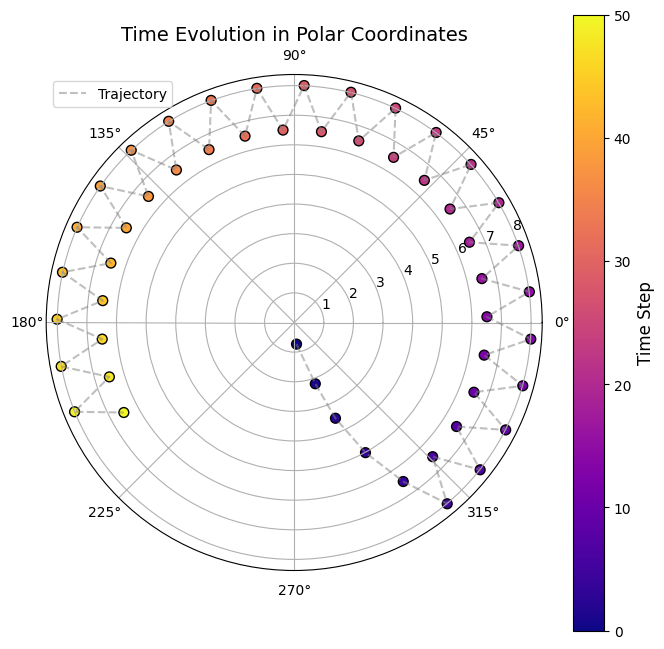

In [943]:
import matplotlib.pyplot as plt


data = state_estimated


r_values = [point[0] for point in data]
theta_values = [point[1] for point in data]


time_steps = range(len(data))
colors = plt.cm.plasma([t / max(time_steps) for t in time_steps])  # Cooler to warmer colors

# Plot in polar coordinates
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, polar=True)



# Plot the lines connecting the points
ax.plot(theta_values, r_values, color='gray', alpha=0.5, linestyle='--', label="Trajectory")

# Plot the scatter points
scatter = ax.scatter(theta_values, r_values, c=time_steps, cmap='plasma', edgecolor='k', s=50)

# Add a colorbar to indicate time evolution
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical')
cbar.set_label('Time Step', fontsize=12)

# Set plot title
ax.set_title('Time Evolution in Polar Coordinates', fontsize=14)
ax.legend(loc="upper left")

plt.show()


Even if the preferred distribution hasnt changed(**R=5 radius circle**) we can see that the equilibrium position of the agent has shifted radially outward since the **state space beyond R=5.8 has a significantly lower obs_noise**, and hence at the cost of the agent being far from the preferred observations, it gains EFE value by **reducing the ambiguity** of the state to observation translation.

NOTE
---
A series of changes where made when we modelled the inhomogeneous state space. Some of these changes are rather upgradations in the function definitions, and its **IDEAL** to incorporate into the function definitions of the first implementation also. Mentioning it here for the benefit of the programer.

1) compute density function to be incorporated into the state_model and obs_model classes
2) instead of using the same obs_density everywhere, computing it before use at every instance(i.e seperately, once in the iteration loop and once in the compute_cross_entropy function).
   this involed predicting the state at the instant using the prediction density and then calling the compute_density function
3) Defining the prefactor as needed(**need to standardize this**)
